# Programmatic Access to Genome Nexus
This notebook gives some examples in Python for programmatic access to http://genomenexus.org. You can run these examples after installing Jupyter. Easiest way for using Jupyter is installing the Python 3 version of anaconda: https://www.anaconda.com/download/. After having that you can install Jupyter with:
```
conda install jupyter
```
For these exampels we also require the Swagger API client reader [Bravado](https://github.com/Yelp/bravado). Unfortunately not yet available in anaconda, but you can get it through `pip`:
```
conda install pip
pip install bravado
```
Let's try connecting to the Genome Nexus API now:

In [23]:
from bravado.client import SwaggerClient
client = SwaggerClient.from_url('https://www.genomenexus.org/v2/api-docs',
                                config={"validate_requests":False,"validate_responses":False})
print(client)

SwaggerClient(https://www.genomenexus.org/)


In [24]:
dir(client)

['annotation_controller',
 'ensembl_controller',
 'info_controller',
 'pdb_controller',
 'pfam_controller']

In [25]:
for a in dir(client):
    client.__setattr__(a[:-len('-controller')], client.__getattr__(a))

In [26]:
variant = client.annotation.fetchVariantAnnotationGET(variant='17:g.41242962_41242963insGA').result()

In [27]:
dir(variant)

['allele_string',
 'annotationJSON',
 'annotation_summary',
 'assembly_name',
 'colocatedVariants',
 'end',
 'hotspots',
 'id',
 'most_severe_consequence',
 'mutation_assessor',
 'my_variant_info',
 'seq_region_name',
 'start',
 'strand',
 'transcript_consequences',
 'variant']

In [28]:
tc1 = variant.transcript_consequences[0] 

In [29]:
dir(tc1)

['amino_acids',
 'canonical',
 'codons',
 'consequence_terms',
 'exon',
 'gene_id',
 'gene_symbol',
 'hgnc_id',
 'hgvsc',
 'hgvsp',
 'polyphen_prediction',
 'polyphen_score',
 'protein_end',
 'protein_id',
 'protein_start',
 'refseq_transcript_ids',
 'sift_prediction',
 'sift_score',
 'transcript_id',
 'variant_allele']

In [30]:
print(tc1)

TranscriptConsequence(amino_acids='Q/LX', canonical=None, codons='cag/cTCag', consequence_terms=['frameshift_variant', 'splice_region_variant'], exon='10/22', gene_id='ENSG00000012048', gene_symbol='BRCA1', hgnc_id=1100, hgvsc='ENST00000309486.4:c.3294_3295dup', hgvsp='ENSP00000310938.4:p.Gln1099LeufsTer11', polyphen_prediction=None, polyphen_score=None, protein_end=1099, protein_id='ENSP00000310938', protein_start=1099, refseq_transcript_ids=['NM_007297.3'], sift_prediction=None, sift_score=None, transcript_id='ENST00000309486', variant_allele='GA')


## Connect with cBioPortal API
[cBioPortal](http://www.cbioportal.org) also uses Swagger for their API. 

In [31]:
import seaborn as sns
%matplotlib inline
sns.set_style("white")
sns.set_context('talk')
import matplotlib.pyplot as plt

In [32]:
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/api-docs',
                                config={"validate_requests":False,"validate_responses":False})
print(cbioportal)

SwaggerClient(https://www.cbioportal.org/api)


In [33]:
for a in dir(cbioportal):
    cbioportal.__setattr__(a.replace(' ', '_').lower(), cbioportal.__getattr__(a))

In [34]:
dir(cbioportal)

['Cancer_Types',
 'Clinical_Attributes',
 'Clinical_Data',
 'Clinical_Events',
 'Copy_Number_Segments',
 'Discrete_Copy_Number_Alterations',
 'Gene_Panels',
 'Genes',
 'Molecular_Data',
 'Molecular_Profiles',
 'Mutations',
 'Patients',
 'Sample_Lists',
 'Samples',
 'Studies']

In [35]:
muts = cbioportal.mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
    molecularProfileId="msk_impact_2017_mutations", # {study_id}_mutations gives default mutations profile for study 
    sampleListId="msk_impact_2017_all", # {study_id}_all includes all samples
    projection="DETAILED" # include gene info
).result()

In [36]:
import pandas as pd

In [37]:
mdf = pd.DataFrame([dict(m.__dict__['_Model__dict'], 
    **m.__dict__['_Model__dict']['gene'].__dict__['_Model__dict']) for m in muts])

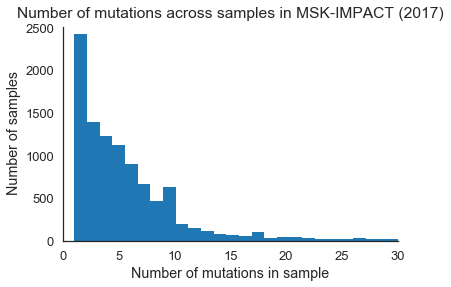

In [38]:
mdf.groupby('uniqueSampleKey').studyId.count().plot(kind='hist', bins=400, xlim=(0,30))
plt.xlabel('Number of mutations in sample')
plt.ylabel('Number of samples')
plt.title('Number of mutations across samples in MSK-IMPACT (2017)')
sns.despine(trim=True)

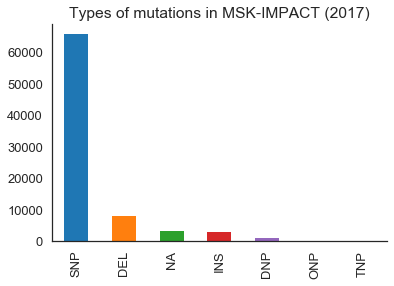

In [39]:
mdf.variantType.astype(str).value_counts().plot(kind='bar')
plt.title('Types of mutations in MSK-IMPACT (2017)')
sns.despine(trim=False)

## Annotate cBioPortal mutations with Genome Nexus
For convenience sake we're using only SNVs here. Eventually there will be an endpoint to help convert pos, ref, alt to the hgvs notation.

In [40]:
snvs = mdf[(mdf.variantType == 'SNP') & (mdf.variantAllele != '-') &  (mdf.referenceAllele != '-')].copy()

In [41]:
# need query string like 9:g.22125503G>C
snvs['hgvs_for_gn'] = snvs.chromosome.astype(str) + ":g." + snvs.startPosition.astype(str) + snvs.referenceAllele + '>' + snvs.variantAllele

In [42]:
assert(snvs['hgvs_for_gn'].isnull().sum() == 0)

In [43]:
import time

qvariants = list(set(snvs.hgvs_for_gn))
gn_results = []
chunk_size = 500
print("Querying {} variants".format(len(qvariants)))
for n, qvar in enumerate([qvariants[i:i + chunk_size] for i in range(0, len(qvariants), chunk_size)]):
    try:
        gn_results += client.annotation.fetchVariantAnnotationPOST(variants=qvar,fields=['hotspots']).result()
        print("Querying [{}, {}]: Success".format(n*chunk_size, min(len(qvariants), n*chunk_size+chunk_size)))
    except Exception as e:
        print("Querying [{}, {}]: Failed".format(n*chunk_size, min(len(qvariants), n*chunk_size+chunk_size)))
        pass
    time.sleep(1) # add a delay, to not overload server

Querying 48671 variants
Querying [0, 500]: Success
Querying [500, 1000]: Success
Querying [1000, 1500]: Success
Querying [1500, 2000]: Success
Querying [2000, 2500]: Success
Querying [2500, 3000]: Success
Querying [3000, 3500]: Success
Querying [3500, 4000]: Success
Querying [4000, 4500]: Success
Querying [4500, 5000]: Success
Querying [5000, 5500]: Success
Querying [5500, 6000]: Success
Querying [6000, 6500]: Success
Querying [6500, 7000]: Success
Querying [7000, 7500]: Success
Querying [7500, 8000]: Success
Querying [8000, 8500]: Success
Querying [8500, 9000]: Success
Querying [9000, 9500]: Success
Querying [9500, 10000]: Success
Querying [10000, 10500]: Success
Querying [10500, 11000]: Success
Querying [11000, 11500]: Success
Querying [11500, 12000]: Success
Querying [12000, 12500]: Success
Querying [12500, 13000]: Success
Querying [13000, 13500]: Success
Querying [13500, 14000]: Success
Querying [14000, 14500]: Success
Querying [14500, 15000]: Success
Querying [15000, 15500]: Succe

In [44]:
gn_dict = {v.id:v for v in gn_results}

In [45]:
def is_sift_high(variant):
    return variant in gn_dict and \
        len(list(filter(lambda x: x.sift_prediction == 'deleterious', gn_dict[variant].transcript_consequences))) > 0
    
def is_polyphen_high(variant):
    return variant in gn_dict and \
        len(list(filter(lambda x: x.polyphen_prediction == 'probably_damaging', gn_dict[variant].transcript_consequences))) > 0

## Check overlap SIFT/PolyPhen-2

In [51]:
snvs['is_sift_high'] = snvs.hgvs_for_gn.apply(is_sift_high)
snvs['is_polyphen_high'] = snvs.hgvs_for_gn.apply(is_polyphen_high)

Text(0.5, 1.0, 'Variants as predicted to have a high impact in MSK-IMPACT (2017)')

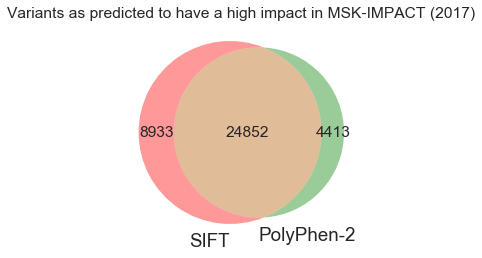

In [52]:
from matplotlib_venn import venn2

venn2(subsets=((snvs.is_sift_high & (~snvs.is_polyphen_high)).sum(),
               (snvs.is_polyphen_high & (~snvs.is_sift_high)).sum(),
               (snvs.is_polyphen_high & snvs.is_sift_high).sum()), set_labels=["SIFT","PolyPhen-2"])
plt.title("Variants as predicted to have a high impact in MSK-IMPACT (2017)")